In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch
from torchvision import datasets, transforms
import sys
sys.path.append("../")
from utils import expspace


In [2]:
def celeba(batch_size):
    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            root="~/datasets/celeba/",
            transform=transforms.Compose(
                [
                    transforms.Resize(64),
                    transforms.CenterCrop(64),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            ),
        ),
        batch_size=batch_size,
        shuffle=False,
    )
    return val_loader


In [3]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=False):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    ind_sort = np.argsort(data_clean[:,0])
    data_clean = data_clean[ind_sort]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
#     print(d)
    
    if log:
        d = np.log(d)
#     regr = linear_model.TheilSenRegressor()
    regr = linear_model.LinearRegression()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [4]:
image_size = 64
n_channels = 3
n_pixel = image_size * image_size * n_channels
val_flag = True

n = 145
min_noise = 0.01
max_noise = 0.1

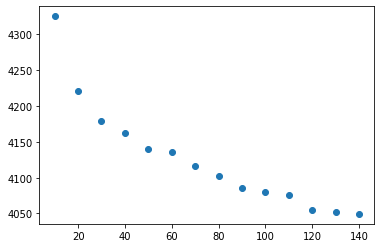

In [5]:
dims = []
ns = list(range(10,150,10))
for n in ns:
    fnames = sorted(glob(f"DATA_DIR/celeba-nodequant-paper-0.01-0.1//ll_*_{n}.txt"))
    to_plot = []
    for f in fnames:
        txt = pd.read_csv(f, sep=" ", header=None)
        if val_flag:
            txt = txt
        if val_flag:
            noise, pz, logdet, _, _ = txt.mean()
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    dim = n_pixel - calculate_coeff(to_plot, 0, 8, log=True, plot=False)
#     print(coef)
    dims.append(dim)
plt.scatter(ns, dims)

In [6]:

val_loader = celeba(1)
fnames = sorted(glob(f"DATA_DIR/celeba-nodequant-paper-0.01-0.1//ll_*_{n}.txt"),
               key=lambda a: float(a.split("_")[-2].split("#")[-1]))
len(fnames)

8

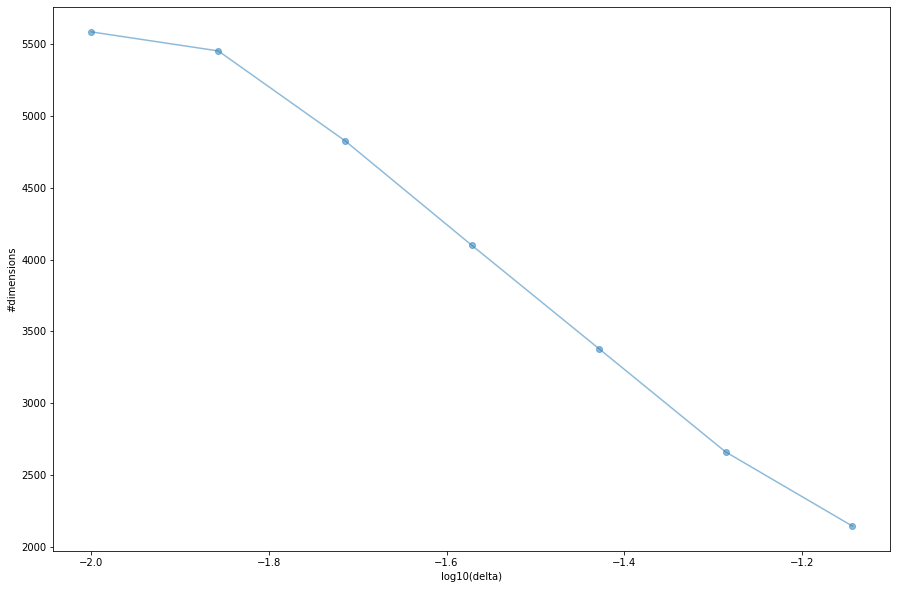

In [12]:
plt.figure(figsize=(15,10))
to_plot = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    if val_flag:
        txt = txt
    if val_flag:
        noise, pz, logdet, _, _ = txt.mean()
    to_plot.append([noise, -(pz + logdet)])
to_plot = np.array(to_plot) + 1e-6
coef_list = [calculate_coeff(to_plot, i, i+2, log=True, plot=False) for i in range(len(to_plot)-1)]
plt.plot(np.sort(np.log10(to_plot[:(len(to_plot)-1),0])), n_pixel - np.array(coef_list), 'o-', alpha=0.5)
plt.xlabel("log10(delta)")
plt.ylabel("#dimensions");

In [7]:
txt_list = []
for f in fnames:
    txt = pd.read_csv(f, sep=" ", header=None)
    txt_list.append(txt)
    
dims = []
for i in range(5000):
    if i % 1000 == 0:
        print(i)
    to_plot = []
    for txt in txt_list:
        if val_flag:
            noise, pz, logdet, _, _ = txt.iloc[i]
        else:
            noise, _, _, pz, logdet = txt.iloc[i]
        to_plot.append([noise, -(pz + logdet)])
    to_plot = np.array(to_plot)
    coef = calculate_coeff(to_plot, 0, 7, log=True, plot=False)
    dims.append(n_pixel - coef)


0
1000
2000
3000
4000


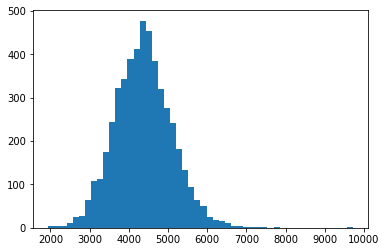

In [14]:
plt.hist(dims, bins=50);

In [15]:
dims = np.array(dims)

In [18]:
val_dataset = [x for x, y in val_loader]

In [16]:
import torch
dims = np.array(dims)
import torch


m = 5
imgs = []
tmp = []
for i in dims.argsort()[:m]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=2))
# imgs.append(dots)
tmp = []
for i in dims.argsort()[2500:(2500+m)]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=2))
# imgs.append(dots)
tmp = []
for i in dims.argsort()[-m:]:
    tmp.append(val_loader.dataset[i][0])
imgs.append(np.concatenate(tmp, axis=2))

full_img = np.concatenate(imgs, axis=1)
full_img = (np.moveaxis(full_img, 0, 2) + 1) / 2
    
plt.imsave("DATA_DIR/celeba.png", full_img)

In [30]:
imgs[5].shape

torch.Size([3, 64, 7])

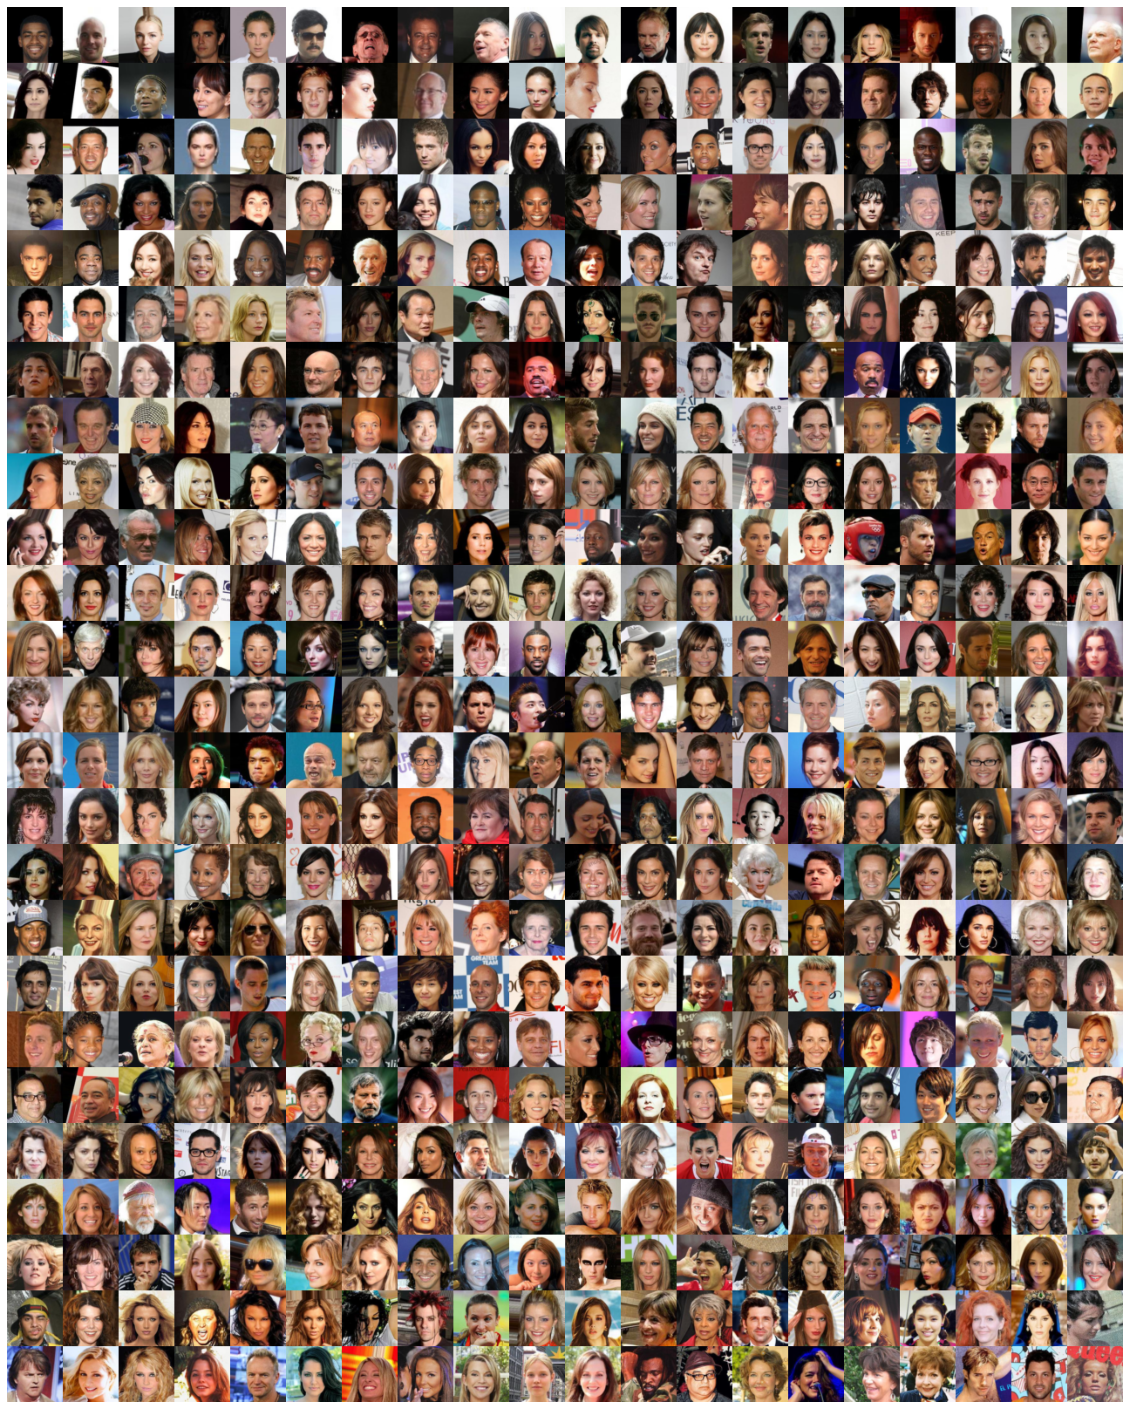

In [21]:
plt.figure(figsize=(20, 40))
m = 200
skip = 10
img_list = []
for i in range(0, 5000, m):
    imgs = []
    for j in range(0, m, skip):
        ind = dims.argsort()[i + j]
        if val_flag:
            imgs.append(val_dataset[ind][0])
    imgs = np.concatenate(imgs, axis=2)
    img_list.append(imgs)
full_img = np.concatenate(img_list, axis=1)
full_img = (np.moveaxis(full_img, 0, 2) + 1) / 2
plt.imshow(full_img)
plt.axis('off')
plt.show()